# Getting started with TensorRT-LLM

In this notebook we are optimizing Bloom 560M for inference using TensorRT-LLM. <br>
We compare inference speed results from the **baseline** model (Huggingface), the **optimized** model, <br>
and the optimized model after **INT8-quantization**.

***Source:***
https://github.com/NVIDIA/TensorRT-LLM/tree/main/examples/bloom

### Installing the NVIDIA Container Toolkit

In [ ]:
!curl -fsSL https://nvidia.github.io/libnvidia-container/gpgkey | sudo gpg --dearmor -o /usr/share/keyrings/nvidia-container-toolkit-keyring.gpg \
  && curl -s -L https://nvidia.github.io/libnvidia-container/stable/deb/nvidia-container-toolkit.list | \
    sed 's#deb https://#deb [signed-by=/usr/share/keyrings/nvidia-container-toolkit-keyring.gpg] https://#g' | \
    sudo tee /etc/apt/sources.list.d/nvidia-container-toolkit.list

!apt-get update

### Installing TensorRT-LLM

In [ ]:
!git clone https://github.com/NVIDIA/TensorRT-LLM/

In [ ]:
!apt-get update && apt-get -y install python3.10 python3-pip openmpi-bin libopenmpi-dev
!pip3 install tensorrt_llm -U --pre --extra-index-url https://pypi.nvidia.com

### Downloading BLOOM

BLOOM is an autoregressive Large Language Model (LLM), trained to continue text from a prompt on vast amounts of text data using industrial-scale computational resources. As such, it is able to output coherent text in 46 languages and 13 programming languages that is hardly distinguishable from text written by humans. BLOOM can also be instructed to perform text tasks it hasn't been explicitly trained for, by casting them as text generation tasks.

In [ ]:
!pip install -r TensorRT-LLM/examples/bloom/requirements.txt

In [ ]:
BLOOM_PATH="TensorRT-LLM/examples/bloom"

!rm -rf $BLOOM_PATH/560M
!mkdir -p $BLOOM_PATH/560M && git clone https://huggingface.co/bigscience/bloom-560m $BLOOM_PATH/560M

### Converting and Building

In [135]:
# Convert checkpoint from HF to TRT-LLM format
!python3 $BLOOM_PATH/convert_checkpoint.py --model_dir $BLOOM_PATH/560M/ \
                --dtype float16 \
                --output_dir $BLOOM_PATH/560M/trt_ckpt/fp16/1-gpu/

[TensorRT-LLM] TensorRT-LLM version: 0.9.0.dev2024030500
0.9.0.dev2024030500
[03/06/2024-20:31:52] [TRT-LLM] [I] Convert by using checkpoint
[03/06/2024-20:31:52] [TRT-LLM] [I] Loading weights from HF BLOOM...
Rank [0] Loading weights: 100%|███████████████████| 1/1 [00:05<00:00,  5.40s/it]
[03/06/2024-20:31:58] [TRT-LLM] [I] Weights loaded. Total time: 00:00:05
Total time of converting checkpoints: 00:00:26


In [ ]:
# Build TensorRT-LLM model from checkpoint
!trtllm-build --checkpoint_dir $BLOOM_PATH/560M/trt_ckpt/fp16/1-gpu/ \
                --gemm_plugin float16 \
                --output_dir $BLOOM_PATH/560M/trt_engines/fp16/1-gpu/

In [ ]:
# Build the BLOOM 560M using a single GPU and apply INT8 weight-only quantization.
!python3 $BLOOM_PATH/convert_checkpoint.py --model_dir $BLOOM_PATH/560M \
                --dtype float16 \
                --use_weight_only \
                --output_dir $BLOOM_PATH/560M/trt_ckpt/int8_weight_only/1-gpu/

!trtllm-build --checkpoint_dir $BLOOM_PATH/560M/trt_ckpt/int8_weight_only/1-gpu/ \
                --gemm_plugin float16 \
                --output_dir $BLOOM_PATH/560M/trt_engines/int8_weight_only/1-gpu/

# Benchmarking

Comparing execution time and **ROUGE** metrics on a **Summarization Task**.

**ROUGE** stands for **Recall-Oriented Understudy for Gisting Evaluation**.<br />
It is a set of metrics used to evaluate the quality of summaries by comparing them to one or more reference summaries.<br />

Since we are using NVIDIA's Python scripts for benchmarking, we need to capture **STDOUT** and parse the results from there.

In [138]:
%%capture bloom_hf_results
# Huggingface
!time python3 $BLOOM_PATH/../summarize.py --test_hf \
                       --hf_model_dir $BLOOM_PATH/560M/ \
                       --data_type fp16 \
                       --engine_dir $BLOOM_PATH/560M/trt_engines/fp16/1-gpu/

In [139]:
%%capture bloom_trt_results
# TensorRT-LLM
!time python3 $BLOOM_PATH/../summarize.py --test_trt_llm \
                       --hf_model_dir $BLOOM_PATH/560M/ \
                       --data_type fp16 \
                       --engine_dir $BLOOM_PATH/560M/trt_engines/fp16/1-gpu/

In [140]:
%%capture bloom_int8_results
# TensorRT-LLM (INT8)
!time python3 $BLOOM_PATH/../summarize.py --test_trt_llm \
                       --hf_model_dir $BLOOM_PATH/560M/ \
                       --data_type fp16 \
                       --engine_dir $BLOOM_PATH/560M/trt_engines/int8_weight_only/1-gpu/

In [ ]:
# Example output captured
print(bloom_int8_results())

# Visualizing the results

#### Parse results from STDOUT

In [142]:
import re

def parse_output(output):
    # Extracting execution time
    time_match = re.search(r'real\s+(\d+)m([\d.]+)s', output.stdout)
    if time_match:
        minutes = int(time_match.group(1))
        seconds = float(time_match.group(2))
        exec_time = minutes * 60 + seconds
    else:
        exec_time = None
    
    rouge_scores = re.findall(r'rouge[12Lsum]+ : ([\d.]+)', output.stdout)
    rouge_scores = [float(score) for score in rouge_scores] if rouge_scores else []
    
    latency_match = re.search(r'total latency: ([\d.]+) sec', output.stdout)
    latency = float(latency_match.group(1)) if latency_match else None
    
    tokens_match = re.search(r'total output tokens: (\d+)', output.stdout)
    total_tokens = int(tokens_match.group(1)) if tokens_match else None
    
    tokens_per_sec_match = re.search(r'tokens per second: ([\d.]+)', output.stdout)
    tokens_per_sec = float(tokens_per_sec_match.group(1)) if tokens_per_sec_match else None
    
    return exec_time, rouge_scores, latency, total_tokens, tokens_per_sec

In [143]:
# For bloom_hf_results
bloom_hf_exec_time, bloom_hf_rouge, _, _, _ = parse_output(bloom_hf_results)

# Only TensorRT-LLM optimized models have Tokens/s, latency, and total tokens
bloom_trt_exec_time, bloom_trt_rouge, bloom_trt_latency, bloom_trt_tokens, bloom_trt_tokens_per_sec = parse_output(bloom_trt_results)
bloom_int8_exec_time, bloom_int8_rouge, bloom_int8_latency, bloom_int8_tokens, bloom_int8_tokens_per_sec = parse_output(bloom_int8_results)

Text(0.5, 0, 'Model')

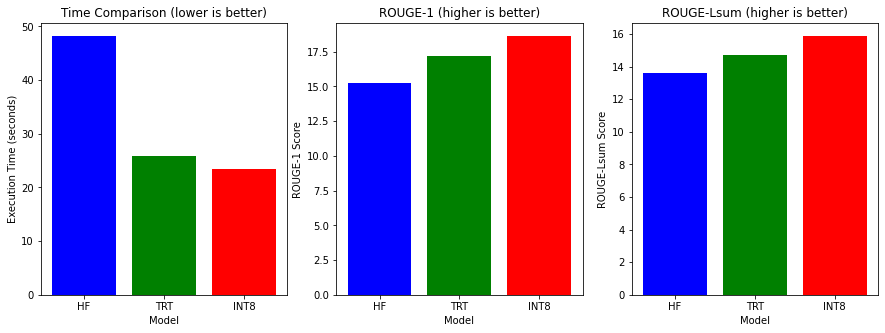

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

# Execution times and Rouge Scores
exec_times = [bloom_hf_exec_time, bloom_trt_exec_time, bloom_int8_exec_time]
models = ['HF', 'TRT', 'INT8']

plt.figure(figsize=(15, 5))

# Plotting execution times
plt.subplot(1, 3, 1)
plt.bar(models, exec_times, color=['blue', 'green', 'red'])
plt.title('Time Comparison (lower is better)')
plt.ylabel('Execution Time (seconds)')
plt.xlabel('Model')

# Plotting ROUGE-1 scores
rouge1_scores = [bloom_hf_rouge[0], bloom_trt_rouge[0], bloom_int8_rouge[0]]
plt.subplot(1, 3, 2)
plt.bar(models, rouge1_scores, color=['blue', 'green', 'red'])
plt.title('ROUGE-1 (higher is better)')
plt.ylabel('ROUGE-1 Score')
plt.xlabel('Model')

# Plotting ROUGE-Lsum scores
rouge_lsum_scores = [bloom_hf_rouge[3], bloom_trt_rouge[3], bloom_int8_rouge[3]]
plt.subplot(1, 3, 3)
plt.bar(models, rouge_lsum_scores, color=['blue', 'green', 'red'])
plt.title('ROUGE-Lsum (higher is better)')
plt.ylabel('ROUGE-Lsum Score')
plt.xlabel('Model')

Text(0.5, 0, 'Model')

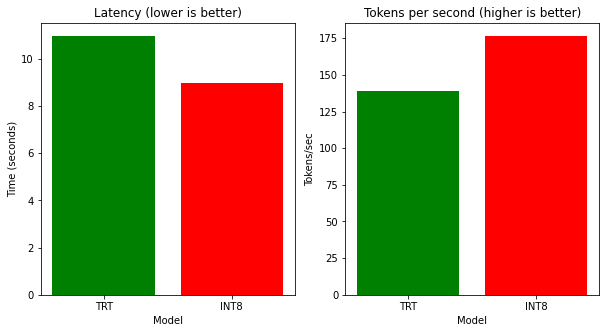

In [145]:
# Latency and Tokens per Sec
latencies = [bloom_trt_latency, bloom_int8_latency]
tps = [bloom_trt_tokens_per_sec, bloom_int8_tokens_per_sec]
models = ['TRT', 'INT8']

plt.figure(figsize=(10, 5))

# Plotting latency times
plt.subplot(1, 2, 1)
plt.bar(models, latencies, color=['green', 'red'])
plt.title('Latency (lower is better)')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')

# Plotting tokens per seconds
rouge1_scores = tps
plt.subplot(1, 2, 2)
plt.bar(models, rouge1_scores, color=['green', 'red'])
plt.title('Tokens per second (higher is better)')
plt.ylabel('Tokens/sec')
plt.xlabel('Model')